In [1]:
import requests
import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import shap

In [2]:
lat="24.8546842"
lon="67.0207055" 
start_time="2025-07-01T00:00"

In [3]:
time = datetime.now()
end_time = time.strftime("%Y-%m-%dT%H:%M")
print(f"Current Date and Time: {end_time}")


Current Date and Time: 2026-02-22T04:44


In [4]:
def get_historical_weather(lat, lon, start, end):
    
    url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={24.8546842}&longitude={67.0207055}&hourly=us_aqi,us_aqi_pm2_5,us_aqi_pm10,us_aqi_nitrogen_dioxide,us_aqi_ozone,us_aqi_sulphur_dioxide,us_aqi_carbon_monoxide&start_hour={start}&end_hour={end}"
    
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

In [5]:
raw_json=get_historical_weather(lat, lon, start_time, end_time)

In [6]:
raw_json

{'latitude': 24.900002,
 'longitude': 67.0,
 'generationtime_ms': 3.932952880859375,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 8.0,
 'hourly_units': {'time': 'iso8601',
  'us_aqi': 'USAQI',
  'us_aqi_pm2_5': 'USAQI',
  'us_aqi_pm10': 'USAQI',
  'us_aqi_nitrogen_dioxide': 'USAQI',
  'us_aqi_ozone': 'USAQI',
  'us_aqi_sulphur_dioxide': 'USAQI',
  'us_aqi_carbon_monoxide': 'USAQI'},
 'hourly': {'time': ['2025-07-01T00:00',
   '2025-07-01T01:00',
   '2025-07-01T02:00',
   '2025-07-01T03:00',
   '2025-07-01T04:00',
   '2025-07-01T05:00',
   '2025-07-01T06:00',
   '2025-07-01T07:00',
   '2025-07-01T08:00',
   '2025-07-01T09:00',
   '2025-07-01T10:00',
   '2025-07-01T11:00',
   '2025-07-01T12:00',
   '2025-07-01T13:00',
   '2025-07-01T14:00',
   '2025-07-01T15:00',
   '2025-07-01T16:00',
   '2025-07-01T17:00',
   '2025-07-01T18:00',
   '2025-07-01T19:00',
   '2025-07-01T20:00',
   '2025-07-01T21:00',
   '2025-07-01T22:00',
   '2025-07-01T23:0

In [7]:
df = pd.DataFrame(raw_json['hourly'])

In [8]:
df

,time,us_aqi,us_aqi_pm2_5,us_aqi_pm10,us_aqi_nitrogen_dioxide,us_aqi_ozone,us_aqi_sulphur_dioxide,us_aqi_carbon_monoxide
0,2025-07-01T00:00,75,75,53,3,19,4,2
1,2025-07-01T01:00,74,74,51,4,20,4,2
2,2025-07-01T02:00,72,72,50,6,20,5,2
3,2025-07-01T03:00,72,72,48,6,21,6,2
4,2025-07-01T04:00,71,71,47,5,21,7,2
...,...,...,...,...,...,...,...,...
5664,2026-02-22T00:00,103,103,68,6,41,6,5
5665,2026-02-22T01:00,103,103,69,11,41,7,4
5666,2026-02-22T02:00,104,104,69,20,41,8,4
5667,2026-02-22T03:00,105,105,70,24,40,9,5


In [9]:
df.isna().sum()

time                       0
us_aqi                     0
us_aqi_pm2_5               0
us_aqi_pm10                0
us_aqi_nitrogen_dioxide    0
us_aqi_ozone               0
us_aqi_sulphur_dioxide     0
us_aqi_carbon_monoxide     0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df['time'] = pd.to_datetime(df['time'])

In [12]:
df.head()

,time,us_aqi,us_aqi_pm2_5,us_aqi_pm10,us_aqi_nitrogen_dioxide,us_aqi_ozone,us_aqi_sulphur_dioxide,us_aqi_carbon_monoxide
0,2025-07-01 00:00:00,75,75,53,3,19,4,2
1,2025-07-01 01:00:00,74,74,51,4,20,4,2
2,2025-07-01 02:00:00,72,72,50,6,20,5,2
3,2025-07-01 03:00:00,72,72,48,6,21,6,2
4,2025-07-01 04:00:00,71,71,47,5,21,7,2


In [13]:
df.columns

Index(['time', 'us_aqi', 'us_aqi_pm2_5', 'us_aqi_pm10',
       'us_aqi_nitrogen_dioxide', 'us_aqi_ozone', 'us_aqi_sulphur_dioxide',
       'us_aqi_carbon_monoxide'],
      dtype='object')

In [14]:
df.columns = df.columns.str.replace('us_', '', regex=False)
print(df.columns)

Index(['time', 'aqi', 'aqi_pm2_5', 'aqi_pm10', 'aqi_nitrogen_dioxide',
       'aqi_ozone', 'aqi_sulphur_dioxide', 'aqi_carbon_monoxide'],
      dtype='object')


In [15]:
df.columns = [col.replace('aqi_', '') if col.startswith('aqi_') else col for col in df.columns]

print(df.columns)

Index(['time', 'aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone',
       'sulphur_dioxide', 'carbon_monoxide'],
      dtype='object')


In [16]:
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour

print(df[['time', 'year', 'month', 'day', 'hour']].head())

                 time  year  month  day  hour
0 2025-07-01 00:00:00  2025      7    1     0
1 2025-07-01 01:00:00  2025      7    1     1
2 2025-07-01 02:00:00  2025      7    1     2
3 2025-07-01 03:00:00  2025      7    1     3
4 2025-07-01 04:00:00  2025      7    1     4


In [17]:
df['day_of_week'] = df['time'].dt.dayofweek

# .dt.dayofweek returns 0 for Monday and 6 for Sunday. 
# 5 (Saturday) and 6 (Sunday) are considered weekends.
df['weekend'] = (df['day_of_week'] >= 5).astype(int)

# Display the result
print(df[['time', 'day_of_week', 'weekend']].sample(20))

                    time  day_of_week  weekend
3465 2025-11-22 09:00:00            5        1
215  2025-07-09 23:00:00            2        0
4652 2026-01-10 20:00:00            5        1
1045 2025-08-13 13:00:00            2        0
4102 2025-12-18 22:00:00            3        0
1526 2025-09-02 14:00:00            1        0
4006 2025-12-14 22:00:00            6        1
1937 2025-09-19 17:00:00            4        0
2341 2025-10-06 13:00:00            0        0
4508 2026-01-04 20:00:00            6        1
1448 2025-08-30 08:00:00            5        1
214  2025-07-09 22:00:00            2        0
3253 2025-11-13 13:00:00            3        0
1914 2025-09-18 18:00:00            3        0
1103 2025-08-15 23:00:00            4        0
1966 2025-09-20 22:00:00            5        1
277  2025-07-12 13:00:00            5        1
959  2025-08-09 23:00:00            5        1
3642 2025-11-29 18:00:00            5        1
4540 2026-01-06 04:00:00            1        0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              5669 non-null   datetime64[ns]
 1   aqi               5669 non-null   int64         
 2   pm2_5             5669 non-null   int64         
 3   pm10              5669 non-null   int64         
 4   nitrogen_dioxide  5669 non-null   int64         
 5   ozone             5669 non-null   int64         
 6   sulphur_dioxide   5669 non-null   int64         
 7   carbon_monoxide   5669 non-null   int64         
 8   year              5669 non-null   int32         
 9   month             5669 non-null   int32         
 10  day               5669 non-null   int32         
 11  hour              5669 non-null   int32         
 12  day_of_week       5669 non-null   int32         
 13  weekend           5669 non-null   int32         
dtypes: datetime64[ns](1), in

In [19]:
df

,time,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,sulphur_dioxide,carbon_monoxide,year,month,day,hour,day_of_week,weekend
0,2025-07-01 00:00:00,75,75,53,3,19,4,2,2025,7,1,0,1,0
1,2025-07-01 01:00:00,74,74,51,4,20,4,2,2025,7,1,1,1,0
2,2025-07-01 02:00:00,72,72,50,6,20,5,2,2025,7,1,2,1,0
3,2025-07-01 03:00:00,72,72,48,6,21,6,2,2025,7,1,3,1,0
4,2025-07-01 04:00:00,71,71,47,5,21,7,2,2025,7,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664,2026-02-22 00:00:00,103,103,68,6,41,6,5,2026,2,22,0,6,1
5665,2026-02-22 01:00:00,103,103,69,11,41,7,4,2026,2,22,1,6,1
5666,2026-02-22 02:00:00,104,104,69,20,41,8,4,2026,2,22,2,6,1
5667,2026-02-22 03:00:00,105,105,70,24,40,9,5,2026,2,22,3,6,1


In [20]:
df.describe()

,time,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,sulphur_dioxide,carbon_monoxide,year,month,day,hour,day_of_week,weekend
count,5669,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000,5669.00000
mean,2025-10-27 02:00:00.000000256,93.482625,92.561827,45.080967,12.263891,35.505204,9.697301,6.172870,2025.221027,7.706827,15.433763,11.491621,3.002646,0.28453
min,2025-07-01 00:00:00,38.000000,38.000000,11.000000,0.000000,2.000000,3.000000,1.000000,2025.000000,1.000000,1.000000,0.000000,0.000000,0.00000
25%,2025-08-29 01:00:00,77.000000,77.000000,35.000000,4.000000,20.000000,6.000000,3.000000,2025.000000,7.000000,8.000000,5.000000,1.000000,0.00000
50%,2025-10-27 02:00:00,88.000000,87.000000,45.000000,8.000000,28.000000,8.000000,5.000000,2025.000000,9.000000,15.000000,11.000000,3.000000,0.00000
75%,2025-12-25 03:00:00,108.000000,106.000000,55.000000,17.000000,41.000000,12.000000,8.000000,2025.000000,11.000000,23.000000,17.000000,5.000000,1.00000
max,2026-02-22 04:00:00,165.000000,161.000000,107.000000,71.000000,165.000000,36.000000,30.000000,2026.000000,12.000000,31.000000,23.000000,6.000000,1.00000
std,NaN,23.953854,23.415532,14.261990,10.907638,26.004875,4.961684,4.028843,0.414975,3.688582,8.763359,6.925616,1.990670,0.45123


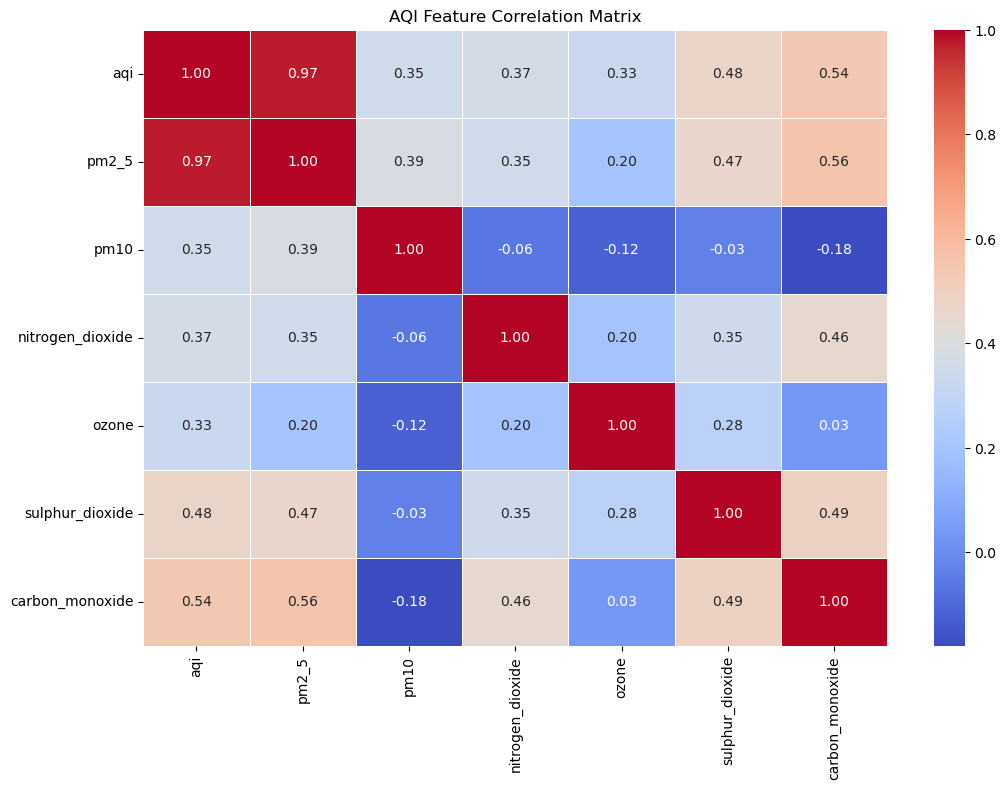

In [21]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,      # Shows the correlation values in the cells
    fmt=".2f",       # Rounds values to 2 decimal places
    cmap='coolwarm', # Blue for negative, Red for positive correlation
    linewidths=0.5
)

plt.title('AQI Feature Correlation Matrix')

plt.show()

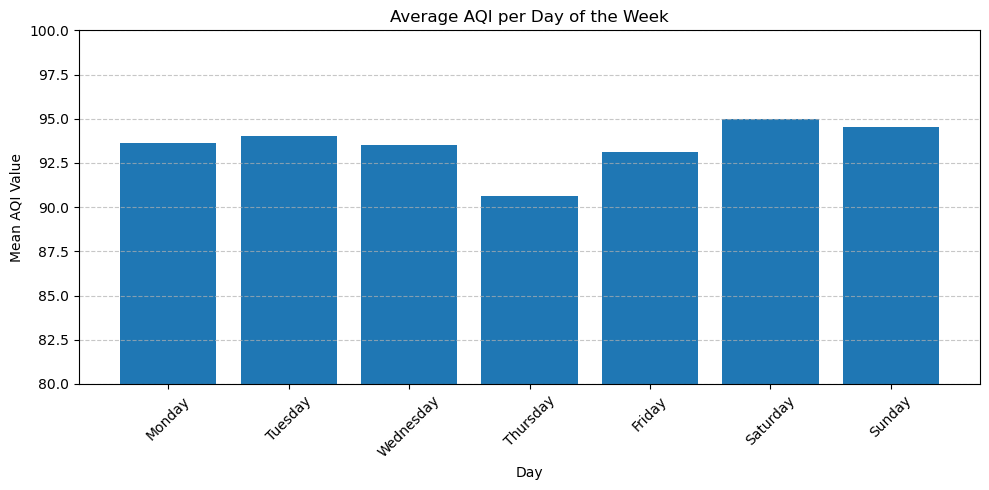

In [22]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 2. Group by Day and calculate the Mean
each_day_avg = df.groupby('day_of_week')['aqi'].mean()

# 3. Plot: Average AQI per Day
plt.figure(figsize=(10, 5))
plt.bar(day_order, each_day_avg.values)
plt.ylim(80, 100)
plt.title('Average AQI per Day of the Week')
plt.ylabel('Mean AQI Value')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

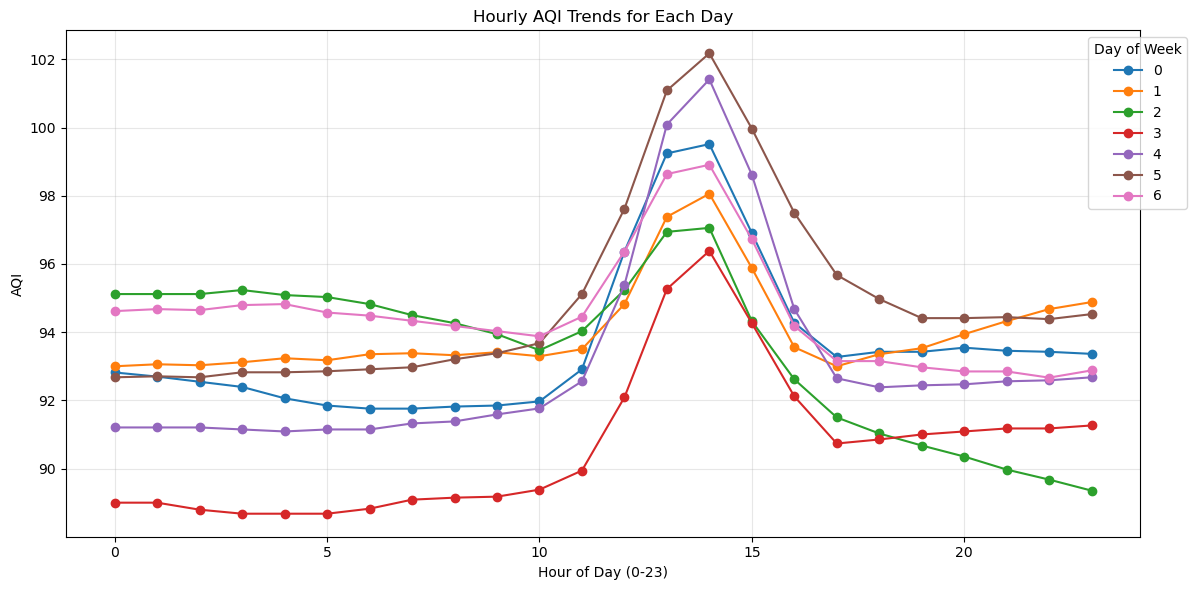

In [23]:
# Advanced Plot: Hourly trend for each day
df['hour'] = df['time'].dt.hour
hourly_pivot = df.pivot_table(values='aqi', index='hour', columns='day_of_week', aggfunc='mean')

hourly_pivot.plot(figsize=(12, 6), marker='o')
plt.title('Hourly AQI Trends for Each Day')
plt.ylabel('AQI')
plt.xlabel('Hour of Day (0-23)')
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

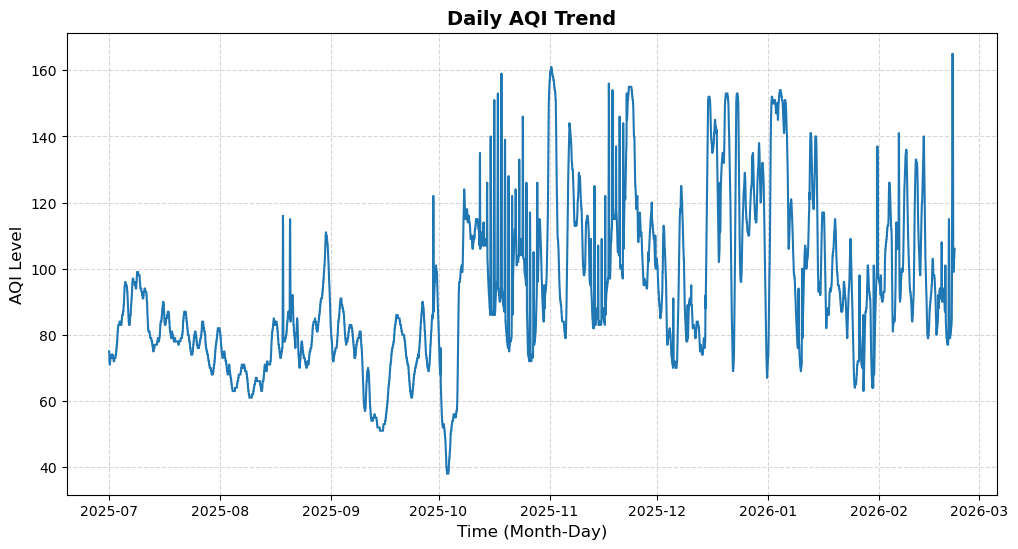

In [24]:
daily_aqi = df.groupby(['year', 'month', 'day'])[['day_of_week','weekend','aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide', 'carbon_monoxide']].mean().reset_index()
daily_aqi['date'] = pd.to_datetime(daily_aqi[['year', 'month', 'day']])
daily_aqi = daily_aqi.sort_values('date')

plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['aqi'])

plt.title('Daily AQI Trend', fontsize=14, fontweight='bold')
plt.xlabel('Time (Month-Day)', fontsize=12)
plt.ylabel('AQI Level', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Format x-axis to be readable (e.g., "01-31 03:00")
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
#plt.xticks(rotation=45)

plt.show()

In [25]:
monthly_aqi=df.groupby("month")[['aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone', 
                                 'sulphur_dioxide', 'carbon_monoxide']].mean()
monthly_aqi

,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,sulphur_dioxide,carbon_monoxide
month,,,,,,,
1,103.528226,102.932796,43.803763,15.611559,38.184140,11.126344,9.001344
2,101.404715,99.876228,45.740668,13.856582,43.119843,9.616896,6.776031
7,81.994624,81.994624,59.918011,5.767473,27.115591,7.036290,2.375000
8,76.206989,75.881720,47.708333,7.353495,26.275538,7.298387,3.400538
9,73.587500,73.438889,43.338889,8.536111,22.516667,7.030556,3.106944
10,93.322581,90.000000,40.534946,12.018817,47.153226,8.560484,6.127688
11,113.051389,111.594444,42.526389,17.850000,43.184722,13.304167,8.997222
12,107.256720,107.083333,37.146505,17.680108,38.725806,13.610215,9.780914


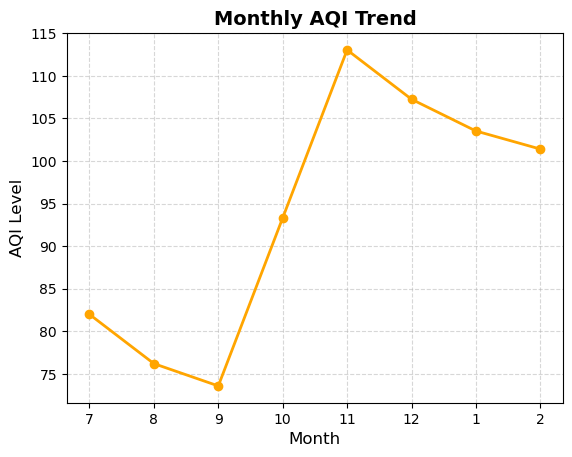

In [26]:
month_order = [7, 8, 9, 10, 11, 12, 1, 2]

monthly_aqi_ordered = monthly_aqi.reindex(month_order)

# We convert the index to strings so Matplotlib treats them as labels in the exact order provided
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered["aqi"], 
         marker='o', linestyle='-', color='orange', linewidth=2)

plt.title('Monthly AQI Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('AQI Level', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

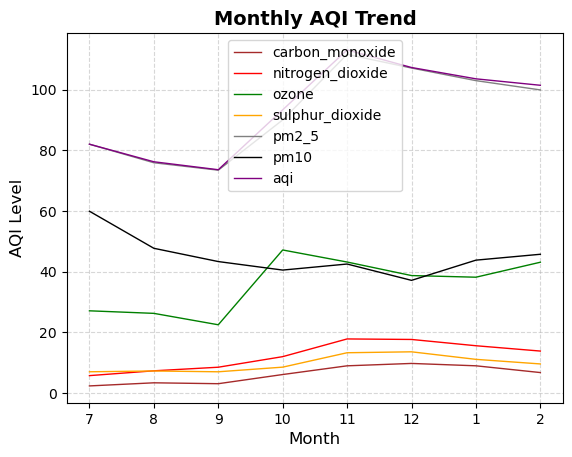

In [27]:
# We convert the index to strings so Matplotlib treats them as labels in the exact order provided
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['carbon_monoxide'], 
         linestyle='-', color='brown', linewidth=1)
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['nitrogen_dioxide'], 
         linestyle='-', color='red', linewidth=1)
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['ozone'], 
         linestyle='-', color='green', linewidth=1)
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['sulphur_dioxide'], 
         linestyle='-', color='orange', linewidth=1)
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['pm2_5'], 
         linestyle='-', color='gray', linewidth=1)
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['pm10'], 
         linestyle='-', color='black', linewidth=1)
plt.plot(monthly_aqi_ordered.index.astype(str), monthly_aqi_ordered['aqi'], 
         linestyle='-', color='purple', linewidth=1)

plt.legend(['carbon_monoxide','nitrogen_dioxide','ozone','sulphur_dioxide','pm2_5','pm10','aqi'])

plt.title('Monthly AQI Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('AQI Level', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [28]:
df

,time,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,sulphur_dioxide,carbon_monoxide,year,month,day,hour,day_of_week,weekend
0,2025-07-01 00:00:00,75,75,53,3,19,4,2,2025,7,1,0,1,0
1,2025-07-01 01:00:00,74,74,51,4,20,4,2,2025,7,1,1,1,0
2,2025-07-01 02:00:00,72,72,50,6,20,5,2,2025,7,1,2,1,0
3,2025-07-01 03:00:00,72,72,48,6,21,6,2,2025,7,1,3,1,0
4,2025-07-01 04:00:00,71,71,47,5,21,7,2,2025,7,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664,2026-02-22 00:00:00,103,103,68,6,41,6,5,2026,2,22,0,6,1
5665,2026-02-22 01:00:00,103,103,69,11,41,7,4,2026,2,22,1,6,1
5666,2026-02-22 02:00:00,104,104,69,20,41,8,4,2026,2,22,2,6,1
5667,2026-02-22 03:00:00,105,105,70,24,40,9,5,2026,2,22,3,6,1


### Finding optimum lag for aqi prediction

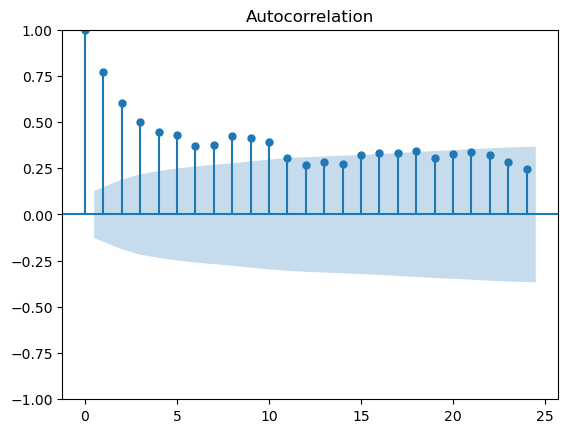

In [30]:
acf_plot=plot_acf(daily_aqi.aqi)

#### it is autoregressive

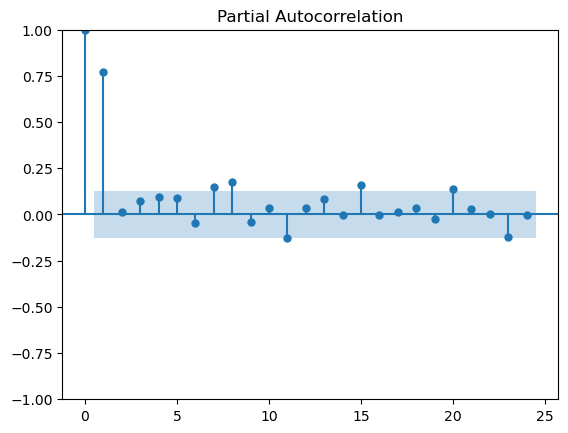

In [32]:
pacf_plot=plot_pacf(daily_aqi.aqi)

#### lag 1 is useful rest are not

In [34]:
daily_aqi

,year,month,day,day_of_week,weekend,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,sulphur_dioxide,carbon_monoxide,date
0,2025,7,1,1.0,0.0,73.250000,73.250000,50.083333,5.541667,25.125000,6.041667,2.333333,2025-07-01
1,2025,7,2,2.0,0.0,73.125000,73.125000,54.166667,6.250000,24.750000,6.708333,2.375000,2025-07-02
2,2025,7,3,3.0,0.0,80.750000,80.750000,62.625000,8.375000,22.708333,9.000000,3.166667,2025-07-03
3,2025,7,4,4.0,0.0,84.666667,84.666667,64.125000,7.708333,23.708333,8.458333,2.833333,2025-07-04
4,2025,7,5,5.0,1.0,93.625000,93.625000,69.375000,4.958333,31.625000,6.833333,2.166667,2025-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2026,2,18,2.0,0.0,94.000000,92.125000,47.375000,14.291667,52.291667,10.041667,6.416667,2026-02-18
233,2026,2,19,3.0,0.0,88.791667,87.083333,39.500000,7.375000,54.291667,6.333333,5.458333,2026-02-19
234,2026,2,20,4.0,0.0,84.791667,78.708333,33.500000,7.375000,62.000000,5.916667,4.708333,2026-02-20
235,2026,2,21,5.0,1.0,107.500000,89.625000,51.083333,9.708333,85.750000,9.375000,5.375000,2026-02-21


In [35]:
daily_aqi.columns

Index(['year', 'month', 'day', 'day_of_week', 'weekend', 'aqi', 'pm2_5',
       'pm10', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide',
       'carbon_monoxide', 'date'],
      dtype='object')

In [36]:
cols = [
    'aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 
    'ozone', 'sulphur_dioxide', 'carbon_monoxide'
]

daily_aqi.sort_values('date')

for col in cols:
    daily_aqi[f'{col}_lag1'] = daily_aqi[col].shift(1)

for col in cols:
    daily_aqi[f'{col}_lag2'] = daily_aqi[col].shift(2)
    
# daily_aqi['rolling_mean_3'] = daily_aqi['aqi'].rolling(3).mean().shift(1)
# daily_aqi['rolling_mean_7'] = daily_aqi['aqi'].rolling(7).mean().shift(1)
# daily_aqi['rolling_std_7'] = daily_aqi['aqi'].rolling(7).std()
# daily_aqi["aqi_lag2"]=daily_aqi["aqi"].shift(2)

df_lagged=daily_aqi.dropna()

In [37]:
df_lagged

,year,month,day,day_of_week,weekend,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,...,ozone_lag1,sulphur_dioxide_lag1,carbon_monoxide_lag1,aqi_lag2,pm2_5_lag2,pm10_lag2,nitrogen_dioxide_lag2,ozone_lag2,sulphur_dioxide_lag2,carbon_monoxide_lag2
2,2025,7,3,3.0,0.0,80.750000,80.750000,62.625000,8.375000,22.708333,...,24.750000,6.708333,2.375000,73.250000,73.250000,50.083333,5.541667,25.125000,6.041667,2.333333
3,2025,7,4,4.0,0.0,84.666667,84.666667,64.125000,7.708333,23.708333,...,22.708333,9.000000,3.166667,73.125000,73.125000,54.166667,6.250000,24.750000,6.708333,2.375000
4,2025,7,5,5.0,1.0,93.625000,93.625000,69.375000,4.958333,31.625000,...,23.708333,8.458333,2.833333,80.750000,80.750000,62.625000,8.375000,22.708333,9.000000,3.166667
5,2025,7,6,6.0,1.0,86.666667,86.666667,63.625000,7.125000,32.041667,...,31.625000,6.833333,2.166667,84.666667,84.666667,64.125000,7.708333,23.708333,8.458333,2.833333
6,2025,7,7,0.0,0.0,93.416667,93.416667,66.583333,9.625000,27.958333,...,32.041667,7.125000,2.125000,93.625000,93.625000,69.375000,4.958333,31.625000,6.833333,2.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2026,2,18,2.0,0.0,94.000000,92.125000,47.375000,14.291667,52.291667,...,39.125000,12.208333,8.208333,96.291667,96.291667,50.000000,10.541667,30.458333,7.583333,4.416667
233,2026,2,19,3.0,0.0,88.791667,87.083333,39.500000,7.375000,54.291667,...,52.291667,10.041667,6.416667,86.000000,85.708333,43.125000,12.750000,39.125000,12.208333,8.208333
234,2026,2,20,4.0,0.0,84.791667,78.708333,33.500000,7.375000,62.000000,...,54.291667,6.333333,5.458333,94.000000,92.125000,47.375000,14.291667,52.291667,10.041667,6.416667
235,2026,2,21,5.0,1.0,107.500000,89.625000,51.083333,9.708333,85.750000,...,62.000000,5.916667,4.708333,88.791667,87.083333,39.500000,7.375000,54.291667,6.333333,5.458333


In [38]:
df_lagged.columns

Index(['year', 'month', 'day', 'day_of_week', 'weekend', 'aqi', 'pm2_5',
       'pm10', 'nitrogen_dioxide', 'ozone', 'sulphur_dioxide',
       'carbon_monoxide', 'date', 'aqi_lag1', 'pm2_5_lag1', 'pm10_lag1',
       'nitrogen_dioxide_lag1', 'ozone_lag1', 'sulphur_dioxide_lag1',
       'carbon_monoxide_lag1', 'aqi_lag2', 'pm2_5_lag2', 'pm10_lag2',
       'nitrogen_dioxide_lag2', 'ozone_lag2', 'sulphur_dioxide_lag2',
       'carbon_monoxide_lag2'],
      dtype='object')

In [39]:
df_lagged=df_lagged.drop(columns=["pm2_5","pm10","nitrogen_dioxide","ozone","sulphur_dioxide","carbon_monoxide"])

In [40]:
df_lagged.columns

Index(['year', 'month', 'day', 'day_of_week', 'weekend', 'aqi', 'date',
       'aqi_lag1', 'pm2_5_lag1', 'pm10_lag1', 'nitrogen_dioxide_lag1',
       'ozone_lag1', 'sulphur_dioxide_lag1', 'carbon_monoxide_lag1',
       'aqi_lag2', 'pm2_5_lag2', 'pm10_lag2', 'nitrogen_dioxide_lag2',
       'ozone_lag2', 'sulphur_dioxide_lag2', 'carbon_monoxide_lag2'],
      dtype='object')

In [41]:
# features = df_lagged[['aqi','aqi_lag1','pm2_5_lag1','pm10_lag1','nitrogen_dioxide_lag1','ozone_lag1','sulphur_dioxide_lag1','carbon_monoxide_lag1']]
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# # Convert the scaled features back into a DataFrame for better readability
# scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

In [42]:
# scaled_df

In [43]:
X=df_lagged.drop(columns=["aqi","date"])
y=df_lagged["aqi"]

In [44]:
X=X.drop(columns=["aqi_lag1","carbon_monoxide_lag1","pm2_5_lag1","sulphur_dioxide_lag2","nitrogen_dioxide_lag2","carbon_monoxide_lag2","pm10_lag2"])

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 2 to 236
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   235 non-null    int32  
 1   month                  235 non-null    int32  
 2   day                    235 non-null    int32  
 3   day_of_week            235 non-null    float64
 4   weekend                235 non-null    float64
 5   pm10_lag1              235 non-null    float64
 6   nitrogen_dioxide_lag1  235 non-null    float64
 7   ozone_lag1             235 non-null    float64
 8   sulphur_dioxide_lag1   235 non-null    float64
 9   aqi_lag2               235 non-null    float64
 10  pm2_5_lag2             235 non-null    float64
 11  ozone_lag2             235 non-null    float64
dtypes: float64(9), int32(3)
memory usage: 21.1 KB


In [46]:
X

,year,month,day,day_of_week,weekend,pm10_lag1,nitrogen_dioxide_lag1,ozone_lag1,sulphur_dioxide_lag1,aqi_lag2,pm2_5_lag2,ozone_lag2
2,2025,7,3,3.0,0.0,54.166667,6.250000,24.750000,6.708333,73.250000,73.250000,25.125000
3,2025,7,4,4.0,0.0,62.625000,8.375000,22.708333,9.000000,73.125000,73.125000,24.750000
4,2025,7,5,5.0,1.0,64.125000,7.708333,23.708333,8.458333,80.750000,80.750000,22.708333
5,2025,7,6,6.0,1.0,69.375000,4.958333,31.625000,6.833333,84.666667,84.666667,23.708333
6,2025,7,7,0.0,0.0,63.625000,7.125000,32.041667,7.125000,93.625000,93.625000,31.625000
...,...,...,...,...,...,...,...,...,...,...,...,...
232,2026,2,18,2.0,0.0,43.125000,12.750000,39.125000,12.208333,96.291667,96.291667,30.458333
233,2026,2,19,3.0,0.0,47.375000,14.291667,52.291667,10.041667,86.000000,85.708333,39.125000
234,2026,2,20,4.0,0.0,39.500000,7.375000,54.291667,6.333333,94.000000,92.125000,52.291667
235,2026,2,21,5.0,1.0,33.500000,7.375000,62.000000,5.916667,88.791667,87.083333,54.291667


In [47]:
y

2       80.750000
3       84.666667
4       93.625000
5       86.666667
6       93.416667
          ...    
232     94.000000
233     88.791667
234     84.791667
235    107.500000
236    104.200000
Name: aqi, Length: 235, dtype: float64

In [48]:
# Split without shuffling to preserve the time order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [49]:
random_forest_model = RandomForestRegressor(    
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

random_forest_model.fit(X_train, y_train)

# 4. Make Predictions
y_train_pred = random_forest_model.predict(X_train)
y_test_pred = random_forest_model.predict(X_test)

# 5. Evaluate
print(f"Train Data: RMSE Score: {root_mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_train, y_train_pred)*100:.2f}%")
print(f"Train Data: R² Score: {r2_score(y_train, y_train_pred):.2f}")


print(f"Test Data: RMSE Score: {root_mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_test_pred)*100:.2f}%")
print(f"Test Data: R² Score: {r2_score(y_test, y_test_pred):.2f}")


Train Data: RMSE Score: 9.92
Train Data: Mean Absolute Error: 6.95
Train Data: Mean Absolute Percentage Error: 7.45%
Train Data: R² Score: 0.83
Test Data: RMSE Score: 12.93
Test Data: Mean Absolute Error: 10.28
Test Data: Mean Absolute Percentage Error: 10.82%
Test Data: R² Score: 0.28


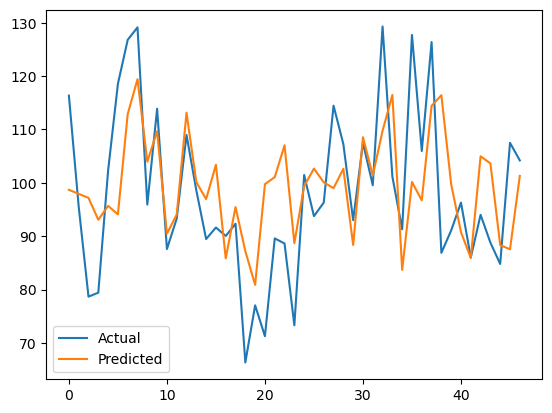

In [50]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')

plt.legend()
plt.show()

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)

# 4. Make Predictions
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

# 5. Evaluate
print(f"Train Data: RMSE Score: {root_mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_train, y_train_pred)*100:.2f}%")
print(f"Train Data: R² Score: {r2_score(y_train, y_train_pred):.2f}")


print(f"Test Data: RMSE Score: {root_mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_test_pred)*100:.2f}%")
print(f"Test Data: R² Score: {r2_score(y_test, y_test_pred):.2f}")


Train Data: RMSE Score: 8.46
Train Data: Mean Absolute Error: 6.45
Train Data: Mean Absolute Percentage Error: 7.10%
Train Data: R² Score: 0.88
Test Data: RMSE Score: 13.02
Test Data: Mean Absolute Error: 9.65
Test Data: Mean Absolute Percentage Error: 10.49%
Test Data: R² Score: 0.27


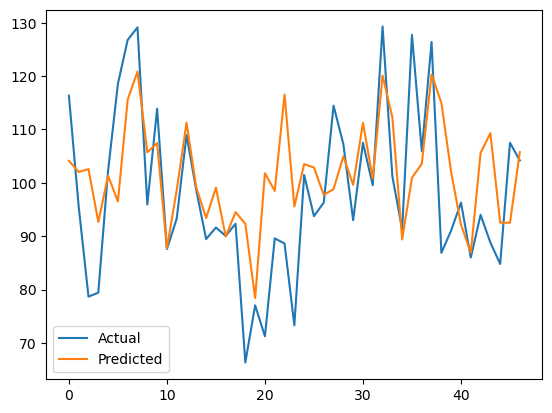

In [52]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')

plt.legend()
plt.show()

In [53]:
from sklearn.linear_model import LinearRegression

# Create model
linear_model = LinearRegression()

# Train model
linear_model.fit(X_train, y_train)

print("Model trained successfully")

y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

print(f"Train Data: RMSE Score: {root_mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_train, y_train_pred)*100:.2f}%")
print(f"Train Data: R² Score: {r2_score(y_train, y_train_pred):.2f}")


print(f"Test Data: RMSE Score: {root_mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_test_pred)*100:.2f}%")
print(f"Test Data: R² Score: {r2_score(y_test, y_test_pred):.2f}")

Model trained successfully
Train Data: RMSE Score: 11.81
Train Data: Mean Absolute Error: 8.50
Train Data: Mean Absolute Percentage Error: 9.03%
Train Data: R² Score: 0.76
Test Data: RMSE Score: 32.94
Test Data: Mean Absolute Error: 29.71
Test Data: Mean Absolute Percentage Error: 32.72%
Test Data: R² Score: -3.65


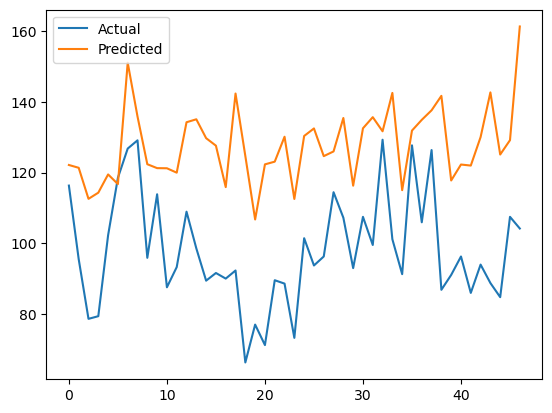

In [54]:
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')

plt.legend()
plt.show()

In [55]:
from sklearn.linear_model import Ridge

# Create model
ridge_model = Ridge(alpha=1)

# Train model
ridge_model.fit(X_train, y_train)

print("Ridge model trained successfully")

y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

print(f"Train Data: RMSE Score: {root_mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Train Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_train, y_train_pred)*100:.2f}%")
print(f"Train Data: R² Score: {r2_score(y_train, y_train_pred):.2f}")


print(f"Test Data: RMSE Score: {root_mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test Data: Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_test_pred)*100:.2f}%")
print(f"Test Data: R² Score: {r2_score(y_test, y_test_pred):.2f}")

Ridge model trained successfully
Train Data: RMSE Score: 11.98
Train Data: Mean Absolute Error: 8.48
Train Data: Mean Absolute Percentage Error: 8.96%
Train Data: R² Score: 0.75
Test Data: RMSE Score: 24.86
Test Data: Mean Absolute Error: 21.87
Test Data: Mean Absolute Percentage Error: 24.17%
Test Data: R² Score: -1.65


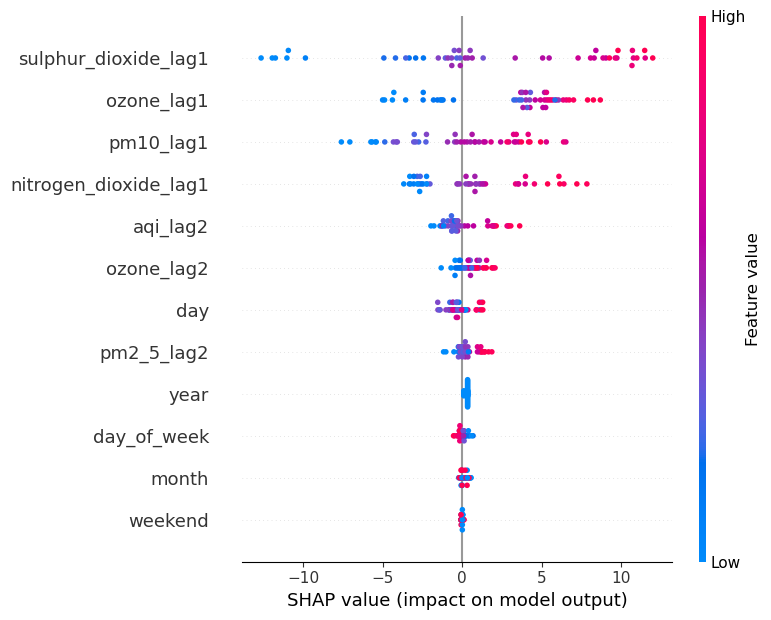

In [56]:
explainer = shap.TreeExplainer(random_forest_model)

# 3. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)